In [6]:
# for now, just request a random composite spectrum from facula_and_spot_creator
# and try to decompose it - aka can we regenerate the w's

# eventually can read in external data or some training data from a large hdf5 file etc

from itertools import product
from pathlib import Path
import astropy
from astropy.table import QTable
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
from astropy.visualization import quantity_support
quantity_support()
from tqdm import tqdm
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.units import Quantity
from joblib import Parallel, delayed
import os

from spots_and_faculae_model.spectrum import spectrum
from spots_and_faculae_model.external_spectrum_reader import read_JWST_fits
from spots_and_faculae_model.spectrum_grid import spectrum_grid, TEFF_COLUMN, LOGG_COLUMN, FLUX_COLUMN, FEH_COLUMN
from spots_and_faculae_model.spectrum import spectrum

if __name__ == "__main__":
	# path of the spectrum to be analysed
	# external_spectrum_path = Path("../../assets/MAST_2025-10-26T19_44_50.934Z - TRAPPIST-1/MAST_2025-10-26T19_44_50.934Z/JWST/jw02589001001_04101_00001-seg001_nis_x1dints.fits")
	external_spectrum_path = Path("../../assets/MAST_2025-10-26T11_57_04.058Z - LTT/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg001_nis_x1dints.fits")
	script_dir = os.getcwd()  # usually the folder where notebook is running")
	wavelength_grid_absolute_path = (script_dir / external_spectrum_path).resolve()

	spectrum_to_decompose : spectrum = read_JWST_fits(wavelength_grid_absolute_path)
	
	orig_spectrum_to_decompose : spectrum = spectrum_to_decompose

	spectrum_to_decompose = spectrum_to_decompose[np.isfinite(orig_spectrum_to_decompose.Fluxes)]
	print("normalising counts")
	spectrum_to_decompose.normalise_Janskys()
	print("finished normalising counts")

	print("reading in hdf5")
	spectral_grid_relative_path = Path("../../assets/spectral_grid.hdf5")
	spectral_grid_absolute_path = (script_dir / spectral_grid_relative_path).resolve()
	spec_grid : spectrum_grid = spectrum_grid.from_hdf5_file(absolute_hdf5_path=spectral_grid_absolute_path)
	print(spec_grid.Table)
	print("finished reading in hdf5")
	


	A = np.empty((0, 0))

	# this is slow but gives us all the parameters saved to the spectral grid
	# T_effs = T_effs[(2300 *u.K <= T_effs) & (T_effs <= 3000*u.K)]

	def process_single_spectral_component(T_eff : Quantity[u.K], FeH : float, log_g : float) -> np.array:
		"""
		returns a np array of astropy quantities with units of Janskys
		"""
		subset_table = spec_grid.Table[(spec_grid.Table[TEFF_COLUMN] == T_eff) &
						  (spec_grid.Table[FEH_COLUMN] == FeH) &
						  (spec_grid.Table[LOGG_COLUMN] == log_g)]
		
		subset : spectrum_grid = spectrum_grid(subset_table)
		
		# remove the indices that were nan in the spectrum
		# must be in the same order as we did for the spectrum_to_decompose
		subset.Table = subset.Table[np.isfinite(orig_spectrum_to_decompose.Fluxes)]
		subset_spectrum = spectrum.from_phoenix_units(wavelengths=spectrum_to_decompose.Wavelengths, phoenix_fluxes=subset.Table[FLUX_COLUMN])
		subset_spectrum.normalise_Janskys()
		# subset_spectrum = subset_spectrum[(1.25 * u.um <= subset_spectrum.Wavelengths) & (subset_spectrum.Wavelengths <= 2 * u.um)]

		return subset_spectrum.Fluxes
	

	# from the grid, fluxes converted to janskys
	normalised_and_converted_spectral_components = Parallel(n_jobs=-1, prefer="threads")(
		delayed(process_single_spectral_component)(T_eff, FeH, log_g) for T_eff, FeH, log_g in tqdm(product(spec_grid.T_effs, spec_grid.FeHs, spec_grid.log_gs), total=len(spec_grid.T_effs) * len(spec_grid.FeHs) * len(spec_grid.log_gs), desc="Appending values to A matrix...")
		)
	
	# spectrum_to_decompose = spectrum_to_decompose[(1.25 * u.um <= spectrum_to_decompose.Wavelengths) & (spectrum_to_decompose.Wavelengths <= 2 * u.um)]

	A = np.column_stack(normalised_and_converted_spectral_components)

normalising counts
finished normalising counts
reading in hdf5
T_eff / K Fe/H / relative to solar ... flux / erg / (s * cm**2 * cm)
    K                              ...         erg / (s cm3)        
--------- ------------------------ ... -----------------------------
   2300.0                     -4.0 ...             1310122917122.013
   2300.0                     -4.0 ...            1315243344493.3623
   2300.0                     -4.0 ...            1317126305700.3953
   2300.0                     -4.0 ...             1315757584430.908
   2300.0                     -4.0 ...            1311654749446.9814
   2300.0                     -4.0 ...            1305586019688.1045
   2300.0                     -4.0 ...              1298325362382.29
   2300.0                     -4.0 ...            1290523354949.2505
   2300.0                     -4.0 ...            1282775942909.8013
      ...                      ... ...                           ...
   4000.0                      1.0 ...  

Appending values to A matrix...: 100%|██████████| 2106/2106 [00:22<00:00, 94.86it/s] 


In [4]:
print("minimising")
# assume that w \in [0,1] : but I think this will only be true for real data if normalisation has been done correctly (???)
result = sp.optimize.lsq_linear(A, [i.value for i in spectrum_to_decompose.Fluxes], bounds = (0, 1), verbose = 2)#, max_iter=600, tol=1e-10, lsmr_tol=1e-5)
print(result)
print(f"sum of weights={np.sum(result.x)}")

minimising
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         1.5082e+09                                    3.80e+06    
       1         3.7667e+08      1.13e+09       1.31e+01       9.51e+05    
       2         9.3972e+07      2.83e+08       6.55e+00       2.38e+05    
       3         2.3396e+07      7.06e+07       3.28e+00       5.94e+04    
       4         5.8006e+06      1.76e+07       1.64e+00       1.49e+04    
       5         1.4263e+06      4.37e+06       8.19e-01       3.71e+03    
       6         3.4486e+05      1.08e+06       4.09e-01       9.28e+02    
       7         8.0604e+04      2.64e+05       2.05e-01       2.32e+02    
       8         1.7576e+04      6.30e+04       1.02e-01       5.77e+01    
       9         3.3154e+03      1.43e+04       5.06e-02       1.42e+01    
      10         4.5771e+02      2.86e+03       2.44e-02       3.31e+00    
      11         3.2902e+01      4.25e+02       1.07e-02       6.42e-01    
 

In [2]:
%matplotlib widget

/tmp/ipykernel_11356/1812527771.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)


     T_eff / K  Fe/H / relative to solar  log_g / log(cm s^(-2))  weight
2066  4000.0 K                      -0.5                     6.0   0.349
1494  3500.0 K                       0.0                     6.0   0.305
2053  4000.0 K                      -1.0                     6.0   0.161
949   3100.0 K                      -3.0                     0.0   0.093
363   2600.0 K                      -4.0                     6.0   0.065
157   2400.0 K                      -1.5                     0.5   0.065
1066  3200.0 K                      -3.0                     0.0   0.036
171   2400.0 K                      -1.0                     1.0   0.011
53    2300.0 K                      -1.0                     0.5   0.009
207   2400.0 K                       0.0                     6.0   0.003


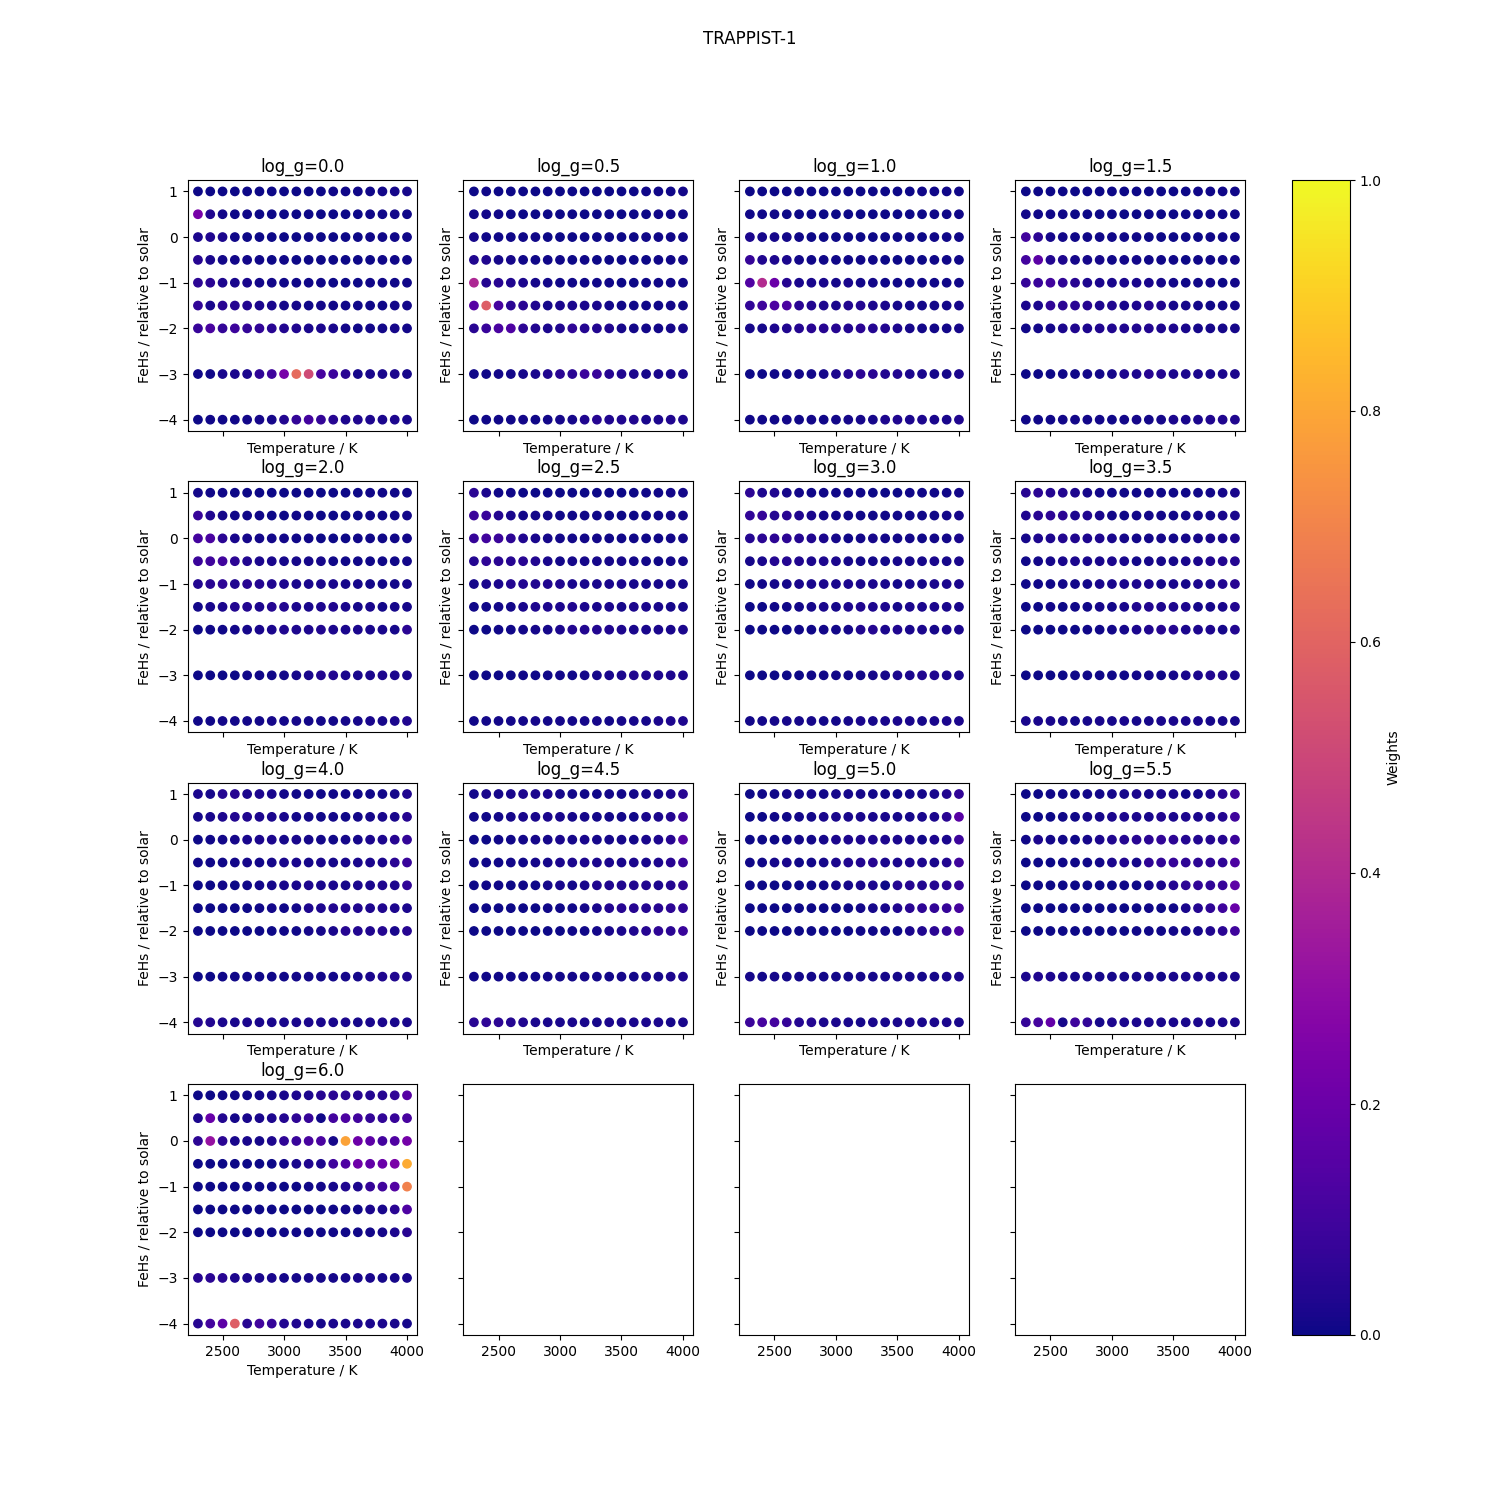

Jy
Jy


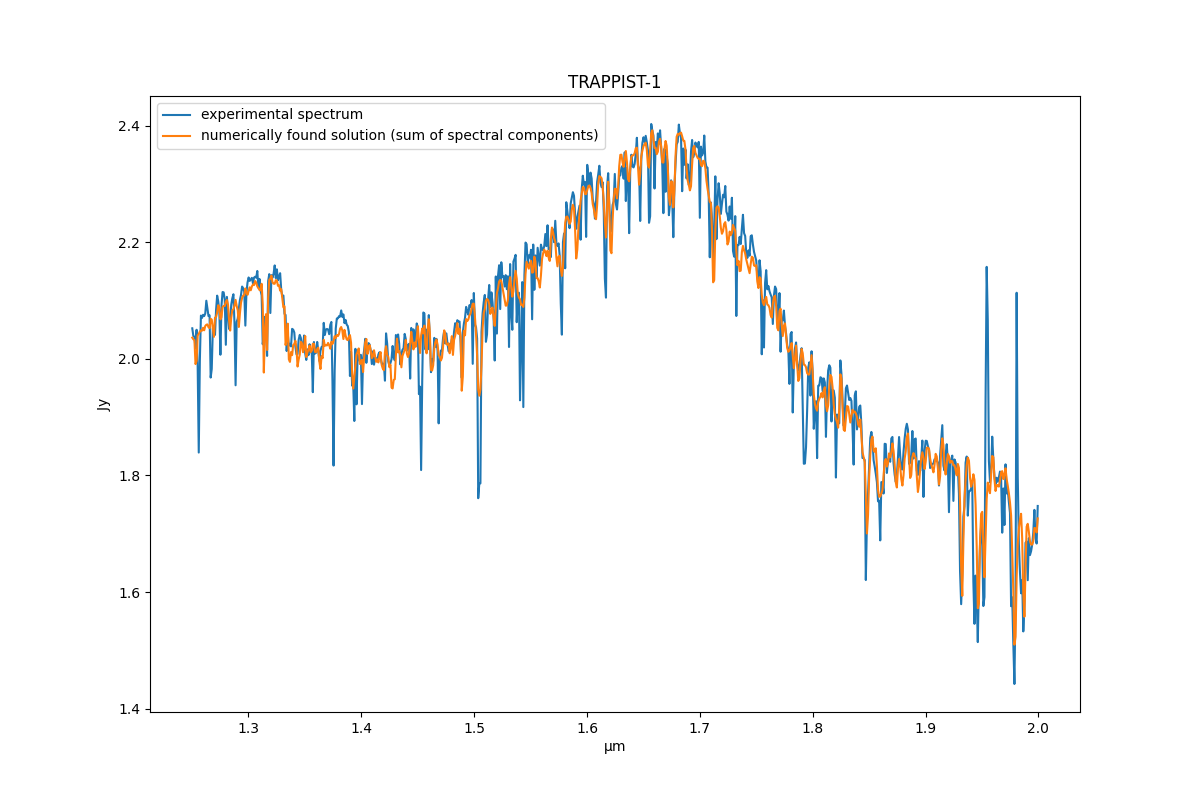

In [5]:

# # # plot some data # # #

result_map = {}
i = 0
for T_eff, FeH, log_g in product(spec_grid.T_effs, spec_grid.FeHs, spec_grid.log_gs):
    key = (T_eff, FeH, log_g)
    result_map[key] = i
    i += 1

WEIGHT_COLUMN : str = "weight"

hash_map = pd.DataFrame(columns=[TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN, WEIGHT_COLUMN])

for T_eff, FeH, log_g in product(spec_grid.T_effs, spec_grid.FeHs, spec_grid.log_gs):
    new_row = {TEFF_COLUMN: T_eff, FEH_COLUMN: FeH, LOGG_COLUMN: log_g, WEIGHT_COLUMN: result.x[result_map[(T_eff, FeH, log_g)]]}
    hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)

print(hash_map.sort_values(WEIGHT_COLUMN, ascending=False).head(10).round(3))

fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.ravel()
for i, log_g in enumerate(spec_grid.log_gs):
    subset = hash_map[hash_map[LOGG_COLUMN] == log_g]
    x_vals = [a.value for a in subset[TEFF_COLUMN]]
    y_vals = subset[FEH_COLUMN]
    z_vals = subset[WEIGHT_COLUMN]

    sc = axes[i].scatter(x_vals, y_vals, c=z_vals**.2, cmap='plasma', vmin=0, vmax=1)

    axes[i].set_title(f"log_g={log_g}")
    axes[i].set_xlabel("Temperature / K")
    axes[i].set_ylabel("FeHs / relative to solar")
    # axes[i].set_xticks(np.arange(np.min(T_effs) / u.K, np.max(T_effs) / u.K + 1, 50) * u.K)
    # axes[i].grid()

STAR_NAME : str = "TRAPPIST-1"
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label("Weights")
fig.suptitle(STAR_NAME)
plt.show()

plt.figure(figsize=(12,8))
plt.title(STAR_NAME)
print(spectrum_to_decompose.Fluxes[0].unit)
print(A[0][0].unit)
determined_spectrum = spectrum(spectrum_to_decompose.Wavelengths, A @ result.x)
# determined_spectrum.normalise_Janskys()
plt.plot(spectrum_to_decompose.Wavelengths, spectrum_to_decompose.Fluxes, label="experimental spectrum")
plt.plot(determined_spectrum.Wavelengths, determined_spectrum.Fluxes, label="numerically found solution (sum of spectral components)")

plt.legend()
plt.show()